## Twitter Sentiment Analysis

__`Natural Language Processing (NLP)`__ is a computer science, artificial intelligence, and linguistics discipline concerned with the development of computational models that process and understand natural language. Making the computer understand the semantic grouping of words (for example, cat and dog are semantically more similar than cat and spoon), text to speech, language translation, and many more are examples.

__`Sentiment Analysis`__ is the use of text analysis techniques to interpret and categorise emotions (positive, negative, and neutral) within text data. Sentiment analysis enables businesses to determine public sentiment toward specific words or topics.

In [1]:
!pip install wordcloud
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# utilities
import re
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report# Start writing code here...

### Importing Dataset

Using the Twitter API, 1.6 million tweets were extracted to create Sentiment140 dataset (http://help.sentiment140.com/for-students). I pruned to 160000 records to improve model construction and sentiment analysis. The tweets were annotated (0 = Negative, 4 = Positive) and can be used to detect sentiment.


It has the following six fields:

- __`sentiment`__ : the tweet's polarity (0 = negative, 4 = positive).
- __`ids`__ : The tweet's identifier (2087)
- __`date`__ : the tweet's date (Sat May 16 23:58:44 UTC 2009)
- __`mark`__ : The query (lyx). This value is NO QUERY if there is no query.
- __`user`__ : the person who tweeted (robotickilldozr)
- __`text`__: the tweet's text (Lyx is cool)
We only need the sentiment and text fields, so we ignore the rest.

Furthermore, we're updating the sentiment field with new values to better reflect the sentiment. __(1 = Positive, 0 = Negative)__

In [3]:
# Importing the dataset nd giving proper column names
DATASET_COLUMNS=['polarity','id','date','flag','username','tweet']
DATASET_ENCODING = "ISO-8859-1"
tw = pd.read_csv('tweets.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
tw.sample(5)

,polarity,id,date,flag,username,tweet
1155707.0,4,1979032963,Sun May 31 01:22:06 PDT 2009,NO_QUERY,TheRealJoelted,http://twitpic.com/6bdyw - I think thats the b...
700010.0,0,2254624508,Sat Jun 20 10:02:08 PDT 2009,NO_QUERY,DrCocaCola,ouch. 9 hours working in retail standing on yo...
304348.0,0,1999716875,Mon Jun 01 20:41:50 PDT 2009,NO_QUERY,heymiranda,@mcrchikie7 ahh i hate my internet it cuts out...
1214212.0,4,1989426218,Mon Jun 01 01:29:49 PDT 2009,NO_QUERY,sharlr,"@Sheamus So, you're pre-cuppa and brekkie then..."
228671.0,0,1978311572,Sat May 30 22:59:42 PDT 2009,NO_QUERY,alifromdablock,I think my feet would feel better if i was bar...


### Exploratory Data Analysis 

In [4]:
# fetching column names
tw.columns

Index(['polarity', 'id', 'date', 'flag', 'username', 'tweet'], dtype='object')

In [5]:
# shape of data
tw.shape

(160001, 6)

In [6]:
# checking null count
tw.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 160001 entries, nan to 63830.0
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  160001 non-null  int64 
 1   id        160001 non-null  int64 
 2   date      160001 non-null  object
 3   flag      160001 non-null  object
 4   username  160001 non-null  object
 5   tweet     160001 non-null  object
dtypes: int64(2), object(4)
memory usage: 8.5+ MB


In [7]:
# fetching data types of columns
tw.dtypes

polarity     int64
id           int64
date        object
flag        object
username    object
tweet       object
dtype: object

In [8]:
# getting unique values for target variable
tw['polarity'].nunique()

2

In [9]:
# picking required columns for analysis
data = tw[['tweet','polarity']]
data

,tweet,polarity
NaN,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1365944.0,@shaaban_o http://twitpic.com/6pmhw this is re...,4
362723.0,"Tucked up in bed, this reply is for me, @Sarca...",0
1130370.0,who want to play rock-paper-scissors-lizard-Sp...,4
1402191.0,@MarcBmusic I'd never heard &quot;The News&quo...,4
...,...,...
107984.0,@heidimontag well my party is over and I'm suf...,0
1388899.0,Yessssssssssssss @DavidArchie's #1 on the Twit...,4
1525262.0,So not fair..not loving getting up at 6 but ho...,4
112378.0,omg. i feel like dead. crazy night yesterday.....,0


In [10]:
# replacing unique values of target variable by 0 and 1
data['polarity'] = data['polarity'].replace(4,1)

/tmp/ipykernel_176/3747111413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['polarity'] = data['polarity'].replace(4,1)


In [11]:
data['polarity'].unique()

array([0, 1])

In [12]:
# storing the data into new variable
data.to_csv('new_tweets.csv')
ntw = pd.read_csv('new_tweets.csv')
ntw

,Unnamed: 0,tweet,polarity
0,NaN,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,1365944.0,@shaaban_o http://twitpic.com/6pmhw this is re...,1
2,362723.0,"Tucked up in bed, this reply is for me, @Sarca...",0
3,1130370.0,who want to play rock-paper-scissors-lizard-Sp...,1
4,1402191.0,@MarcBmusic I'd never heard &quot;The News&quo...,1
...,...,...,...
159996,107984.0,@heidimontag well my party is over and I'm suf...,0
159997,1388899.0,Yessssssssssssss @DavidArchie's #1 on the Twit...,1
159998,1525262.0,So not fair..not loving getting up at 6 but ho...,1
159999,112378.0,omg. i feel like dead. crazy night yesterday.....,0


In [13]:
del ntw['Unnamed: 0']

### Preprocess Data
Text preprocessing has long been considered an important step in Natural Language Processing (NLP) tasks. It converts text into a more digestible format, allowing machine learning algorithms to perform better.



The preprocessing steps are as follows:

- Lower Case: All texts are converted to lowercase.
- URLs that begin with "http," "https," or "www" are replaced with "URL."
- Emoji Replacement: Emojis can be replaced by using a pre-defined dictionary that includes emojis and their meanings. (For example, ":)" to "EMOJIsmile")
- Usernames should be replaced with the word "USER" instead of @Usernames. (For example, "@Kaggle" to "USER")
- Non-Alphabets are removed by replacing all characters except Digits and Alphabets with a space.
- Consecutive letter replacement: 3 or more consecutive letters are replaced by 2 letters. (eg: "Hiiiii" to "Hii")
- Short Words are Removed: Words with a length of less than two are removed.
- Remove Stopwords: Stopwords are English words that add little meaning to a sentence. They can be safely ignored without affecting the sentence's meaning. (For example, "the," "he," or "have")
- Lemmatization is the process of converting a word to its root form. (For example, "Great" to "Good")

In [14]:
# separating tweet and sentiment for data preprocessing
tweet, sentiment = list(ntw['tweet']), list(ntw['polarity'])

In [15]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [16]:
# clean the tweets 
def preprocess(textdata):
    clean_tweet = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)

        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        

        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        

        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)

        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        clean_tweet.append(tweetwords)
        
    return clean_tweet

In [17]:
import time
t = time.time()
clean_tweet = preprocess(tweet)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 15 seconds


In [18]:
tweet[0:5]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 '@shaaban_o http://twitpic.com/6pmhw this is real traffic   Taken on  Friday night in Mex. Great fun ',
 'Tucked up in bed, this reply is for me, @Sarcasmoo, so I remember to send some apologies to people on msn/twitter/fb later  *damn vodka*',
 'who want to play rock-paper-scissors-lizard-Spok with me? ',
 "@MarcBmusic I'd never heard &quot;The News&quot; before - like very much, thanks for broadening my horizons. Now checking out &quot;Comin' Up&quot; "]

In [19]:
clean_tweet[0:5]

['USER URL aww that bummer you shoulda got david carr of third day to do it EMOJIwink ',
 'USER URL this is real traffic taken on friday night in mex great fun ',
 'tucked up in bed this reply is for me USER so remember to send some apology to people on msn twitter fb later damn vodka ',
 'who want to play rock paper scissors lizard spok with me ',
 'USER never heard quot the news quot before like very much thanks for broadening my horizon now checking out quot comin up quot ']

### Analyzing Data


A __`word cloud`__ is a graphical representation of the frequency of words. The larger the word appears in the image generated, the more frequently the term appears in the text being analysed. Word clouds are becoming more popular as a simple tool for determining the focus of written material.

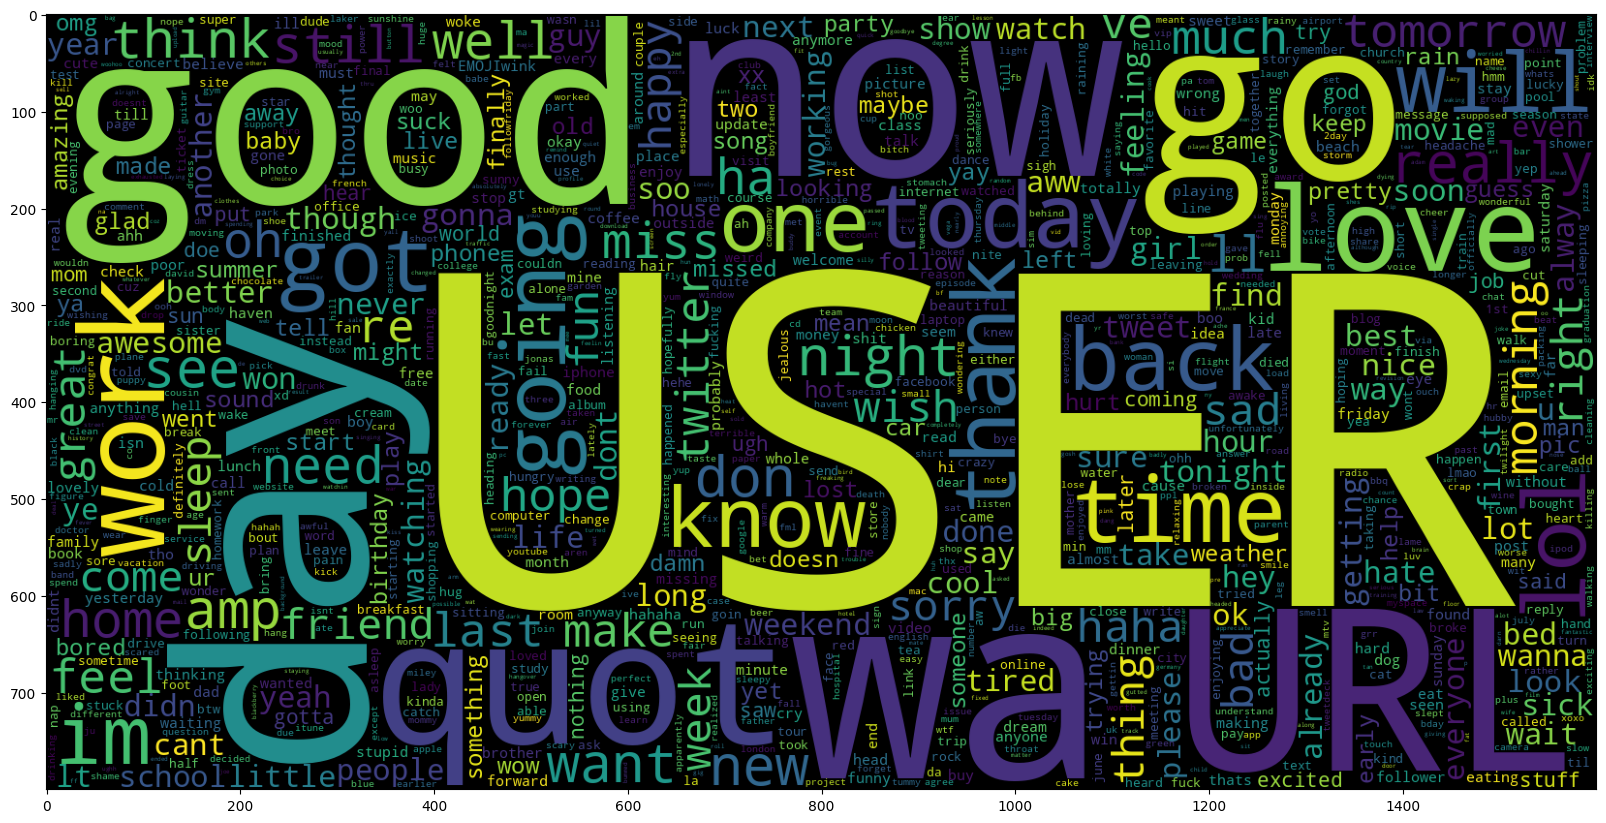

In [20]:
negative_data = clean_tweet[:80000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(negative_data))
plt.imshow(wc)

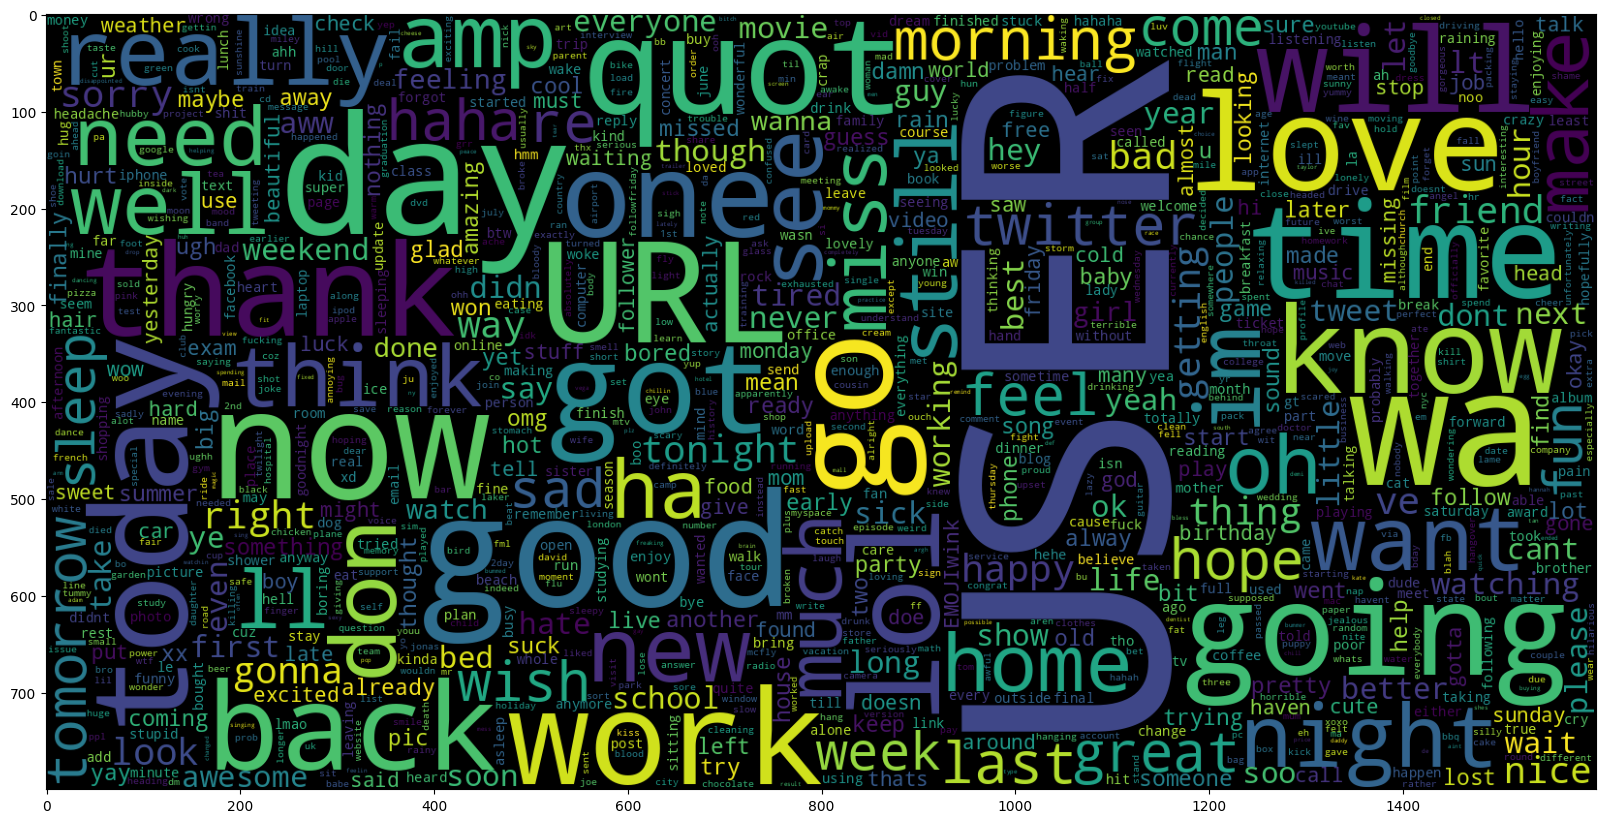

In [21]:
positive_data = clean_tweet[80000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(positive_data))
plt.imshow(wc)

## Feature Extraction
### Bag of Words 

__`Bag of words (BoW)`__ is a traditional text representation technique that is widely used in NLP, particularly in text classification problems. The main idea is to represent the text under consideration as a bag (collection) of words, ignoring the order and context.

![Picture title](image-20221205-132231.png)

In [22]:
# I once more trimmed data from 160000 to 10000 since the kernel kept dying.
clean_tweet = clean_tweet[:10000]

In [23]:
# Create the bag of words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features= 1500)# We restrict the words to 1500 which keeps the most frequent words

In [24]:
X = cv.fit_transform(clean_tweet).toarray()# independent variables

In above code, the corpus of cleaned data is transformed into a numeric array format, which makes it easier for computers to understand and analyse the sentiment of the supplied text.

In [25]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
print(cv.get_feature_names())

['00', '10', '100', '11', '12', '15', '16', '17', '1st', '20', '2009', '24', '2day', '2morrow', '2nd', '30', '33', '40', '50', '6am', 'able', 'about', 'absolutely', 'abt', 'account', 'ache', 'acting', 'active', 'actually', 'adam', 'add', 'advice', 'africa', 'after', 'afternoon', 'again', 'against', 'age', 'ago', 'agree', 'ah', 'ahead', 'ahh', 'ain', 'aint', 'air', 'airport', 'ala', 'alarm', 'album', 'all', 'allowed', 'almost', 'alone', 'along', 'alot', 'already', 'alright', 'also', 'although', 'always', 'am', 'amazing', 'america', 'american', 'amp', 'an', 'and', 'annoying', 'another', 'answer', 'any', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apartment', 'app', 'apparently', 'appreciate', 'are', 'area', 'aren', 'argh', 'arm', 'around', 'arrived', 'art', 'article', 'as', 'ask', 'asked', 'asking', 'asleep', 'at', 'ate', 'atl', 'australia', 'aw', 'awake', 'award', 'away', 'awesome', 'awful', 'awhile', 'aww', 'babe', 'baby', 'back', 'background', 'bad', 'bag', 'bal

In [27]:
X.shape

(10000, 1500)

In [28]:
# Because input variables with irregular numbers of samples can result in errors, I sliced the data to fit the shape of X.
y = ntw.iloc[:10000, 1].values # dependent variable (These are your Liked values from the dataset)

## Modeling
### Naive Bayes Model

In [29]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
# Fitting classifier to the Training set
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(X_train, y_train)
# Predicting the Test set results 
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix

# Evaluate the results
confusion_matrix(y_test, y_pred)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6245

### KNN Model

In [30]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fitting classifier to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski', p =2)
classifier.fit(X_train, y_train)

# Predicting the Test set results 

y_pred = classifier.predict(X_test)


# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

# Evaluate the results
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.598

### Linear Support Vector Machine (Linear SVC)

In [31]:
# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fitting classifier to the Training set

from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train, y_train)


# Predicting the Test set results 
y_pred = clf.fit(X_train, y_train).predict(X_test)
# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix

# Evaluate the results
confusion_matrix(y_test, y_pred)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7165

### Decision Tree Classification Model

In [32]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size = 0.25, random_state = 0)

# Fitting classifier to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)


# Predicting the Test set results 
y_pred = classifier.predict(X_test)

# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

# Evaluate the results
accuracy_score(y_test, y_pred)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6312

### Random Forest Model

In [33]:
#Splitting the dataset into the Training set and Test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Fitting classifier to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10, criterion = 'entropy')
classifier.fit(X_train, y_train)


# Predicting the Test set results 
y_pred = classifier.predict(X_test)

# Make the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

# Evaluate the results
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.715

## Feature Extraction
### TF IDF

The term __`term frequency-inverse document frequency`__, or __`TF-IDF`__, method attempts to quantify the importance of a given word in relation to other words in the document and in the corpus.

The intuition behind __`TF-ID`__ is as follows: 
if a word w appears frequently in a sentence S1 but not frequently in the rest of the Sentences Sn in the corpus, then the word w must be very important to the Sentence S1. The importance of w should increase in proportion to its frequency in S1 (how many times that word appears in sentence S1), but it should decrease in proportion to the frequency of the word in other Sentence Sn in the corpus.


![Picture title](image-20221205-120151.png)

__The TF-IDF indicates the importance of the word in understanding the document or dataset. Let us illustrate with an example. Assume you have a dataset in which students write an essay about My House. The word an appears frequently in this dataset; it is a high frequency word when compared to other words in the dataset. Other words in the dataset, such as home, house, rooms, and so on, appear less frequently, so their frequency is lower, and they carry more information than the word. This is the idea behind TF-IDF.__



### Differenec between BOW and TF IDF

#### CountVectorizer simply counts the number of times a word appears in a document (using a bag-of-words approach)

#### while TF-IDF Vectorizer takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
clean_tweet = vectorizer.fit_transform(clean_tweet).toarray()

In [36]:
X = clean_tweet

In [37]:
X.shape

(10000, 1496)

## Modeling
### Random Forest Model

In [38]:
#Splitting the dataset into the Training set and Test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Fitting classifier to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10, criterion = 'entropy')
classifier.fit(X_train, y_train)


# Predicting the Test set results 
y_pred = classifier.predict(X_test)

# Make the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

# Evaluate the results
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6795

### Decision Tree Model

In [39]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size = 0.25, random_state = 0)

# Fitting classifier to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)


# Predicting the Test set results 
y_pred = classifier.predict(X_test)

# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

# Evaluate the results
accuracy_score(y_test, y_pred)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6484

### Linear Support Vector Machine 

In [40]:
# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fitting classifier to the Training set

from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train, y_train)


# Predicting the Test set results 
y_pred = clf.fit(X_train, y_train).predict(X_test)
# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix

# Evaluate the results
confusion_matrix(y_test, y_pred)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.703

### KNN Model

In [41]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fitting classifier to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski', p =2)
classifier.fit(X_train, y_train)

# Predicting the Test set results 

y_pred = classifier.predict(X_test)


# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

# Evaluate the results
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5545

### Naive Bayes Model

In [42]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
# Fitting classifier to the Training set
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(X_train, y_train)
# Predicting the Test set results 
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix

# Evaluate the results
confusion_matrix(y_test, y_pred)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6475

### Evaluate the performance of each of these models. Create a table to highlight the differences across both the approaches.

In [43]:
from tabulate import tabulate

data_bag_of_words = [["Random Forest Model", 0.704,  0.684], 
        ["Decision Tree", 0.6312, 0.6484], 
        ["Linear SVC", 0.7355, 0.703], 
        ["KNN", 0.608, 0.587],
        ["Naive Bayes", 0.6245, 0.6475]]

col_names = ["Model_Name", "Bag of Words - Accuracy", "TF IDF - Accuracy"]

print(tabulate(data_bag_of_words, headers=col_names, tablefmt="grid", showindex="always"))

+----+---------------------+---------------------------+---------------------+
|    | Model_Name          |   Bag of Words - Accuracy |   TF IDF - Accuracy |
+====+=====================+===========================+=====================+
|  0 | Random Forest Model |                    0.704  |              0.684  |
+----+---------------------+---------------------------+---------------------+
|  1 | Decision Tree       |                    0.6312 |              0.6484 |
+----+---------------------+---------------------------+---------------------+
|  2 | Linear SVC          |                    0.7355 |              0.703  |
+----+---------------------+---------------------------+---------------------+
|  3 | KNN                 |                    0.608  |              0.587  |
+----+---------------------+---------------------------+---------------------+
|  4 | Naive Bayes         |                    0.6245 |              0.6475 |
+----+---------------------+------------------------

#### According to the analysis presented above, __`Support Vector Machin`__ models are the most effective at predicting sentiment analysis from sanitised text using Bag of Words and TF IDF approaches.

#### Saving the Model into Pickle file.

In [44]:
import pickle

file = open('vectorizer.pickle','wb')
pickle.dump(vectorizer, file)
file.close()

file = open('svm.pickle','wb')
pickle.dump(clf, file)
file.close()

In [45]:
#Predict using saved model
def load_models():
    # Load the vectoriser.
    file = open('vectorizer.pickle', 'rb')
    vectorizer = pickle.load(file)
    file.close()
    # Load the sv, Model.
    file = open('svm.pickle', 'rb')
    clf = pickle.load(file)
    file.close()
    return vectorizer, clf

In [46]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectorizer.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

#### Start predicting values from saved SVM model (.pkl file)

In [59]:
if __name__=="__main__":
    # Loading the models.
    vectorizer, clf = load_models()
    
    # Text to classify should be in a list.
    text = ["@airbnbhelp @airbnb I've had multiple conversations with your customer support team and they are absolutely worthless." 
            "No one has been able to address my issue or process the refund I was promised.",

            "High quality pants. Very comfortable and great for sport activities. Good price for nice quality! this product was good. I recommend to all fans of sports",
            
            "I’ve seen the leaks…"
            "And as I said with Starfield , GTA 6 and other games"
            "Developers should be allowed to show a game on their terms."
            "I feel sorry for the devs."
            "I don’t know about you, but I like surprises",
            
            "I'm definitely buying the 4 pack, thanks"]
    
    df = predict(vectorizer, clf, text)
    print(df.head())

                                                text sentiment
0  @airbnbhelp @airbnb I've had multiple conversa...  Negative
1  High quality pants. Very comfortable and great...  Positive
2  I’ve seen the leaks…And as I said with Starfie...  Negative
3           I'm definitely buying the 4 pack, thanks  Positive


#### The first response, which is what we can see here, indicates positive feelings for marketing analysis. Another comment demonstrates awful customer service and customer problems, leading the model to state that it has a negative sign and the final one is a praise for the jeans the customer purchased from the store and loves it.

________


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e05e0758-2c0e-4528-9f5b-c4be2d64b665' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>